In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

try:
    print(f"Found GPU at : {device_name}")
except:
    print("GPU device not found.")

Found GPU at : /device:GPU:0


In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
    print(f"Number of GPU's available : {torch.cuda.device_count()}")
    print(f"GPU device name : {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available, using CPU instead")
    device = torch.device("cpu")
    use_cuda = False

Number of GPU's available : 1
GPU device name : Tesla T4


In [ ]:
import pandas as pd
#read train.csv and test.csv
train_df = pd.read_csv("/content/drive/MyDrive/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/test.csv")
#check shape of datasets
train_df.shape, test_df.shape

((42000, 785), (28000, 784))

In [ ]:
from PIL import Image
class MyDataset(Dataset):
    
    def __init__(self, df, train=False, transform=None):
        self.df = df
        self.transform = transform
        self.train = train
        
        if train:
            self.y_data = torch.tensor(np.asarray(self.df['label'].values))
            self.X_data = np.asarray(self.df.drop('label', axis=1).values).reshape(self.df.shape[0], 28, 28)
        else:
            self.X_data = np.asarray(self.df.values).reshape(self.df.shape[0], 28, 28)
            
        
    def __getitem__(self, index):
             
        image = self.X_data[index]
        image = Image.fromarray(np.uint8(image), mode='L')
        
        if self.transform:
            image = self.transform(image)

        if self.train:
            return image, self.y_data[index]
        else:
            return image
            
    
    def __len__(self):
        return self.df.shape[0]

In [ ]:
#training data transformation
train_transforms = transforms.Compose([
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7,7), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,))
])

#validation data transformation
val_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,)),
])

#testing data transformation
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,)),
])

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'])
train_df.shape, val_df.shape

((33600, 785), (8400, 785))

In [ ]:
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
# get train, val and test dataset
train_dataset = MyDataset(train_df, train=True, transform=train_transforms)
val_dataset = MyDataset(val_df, train=True, transform=val_transforms)
test_dataset = MyDataset(test_df, train=False, transform=test_transforms)


In [ ]:
# get train, val and test dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, **kwargs)

In [ ]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1block = nn.Sequential(
            nn.Conv2d(1, 8, 3),                            #(-1,28,28,1)>(-1,3,3,1,8)>(-1,26,26,8)>3
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3),                           #(-1,26,26,8)>(-1,3,3,8,8)>(-1,24,24,8)>5
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 10, 3),                           #(-1,24,24,8)>(-1,3,3,8,10)>(-1,22,22,10)>7
            nn.BatchNorm2d(10),
            nn.ReLU(),
        )

        self.pool1block = nn.Sequential(
            nn.MaxPool2d(2,2),                              #(-1,22,22,10)>(-1,11,11,10)>8
        )

        self.conv2block = nn.Sequential(
            nn.Conv2d(10, 16, 3),                           #(-1,11,11,10)>(-1,3,3,10,16)>(-1,9,9,16)>12
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Conv2d(16, 16, 3),                           #(-1,9,9,16)>(-1,3,3,16,16)>(-1,7,7,16)>16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Conv2d(16, 16, 3),                           #(-1,7,7,16)>(-1,3,3,16,16)>(-1,5,5,16)>20
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.01),
        )

        self.avgpool = nn.AvgPool2d(5)                      #(-1,5,5,16)>(-1,1,1,16)>28
        self.conv3 = nn.Conv2d(16, 10, 1)                   #(-1,1,1,16)>(-1,1,1,16,10)>(-1,1,1,10)>28  

        
    def forward(self, x):
        x = self.conv1block(x)
        x = self.pool1block(x)
        x = self.conv2block(x)
        x = self.avgpool(x)
        x = self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             584
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             730
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
        MaxPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,456
      BatchNorm2d-12             [-1, 16, 9, 9]              32
             ReLU-13             [-1, 16, 9, 9]               0
          Dropout-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
def regularize_loss(model, loss, decay, norm_value):
    r_loss = 0
    # get sum of norm of parameters
    for param in model.parameters():
        r_loss += torch.norm(param, norm_value)
    # update loss value
    loss += decay * r_loss

    return loss

In [ ]:
def save_ckp(state, checkpoint_fpath):
    
    f_path = checkpoint_fpath
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    
def load_ckp(checkpoint_fpath, model, optimizer):
    
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # get epoch
    epoch = checkpoint['epoch']
    # get val_max_acc
    val_max_acc = checkpoint['valid_max_acc']
    # get misclassified images
    misclassified_images = checkpoint['misclassified_images']
    # return model, optimizer, epoch, val_max_acc, misclassified_images
    return model, optimizer, epoch, val_max_acc, misclassified_images

**Here,I will define our network for training. This network has less than 8k parameters with a receptive field of 28 at last layer.**

In [ ]:
from tqdm import tqdm
import numpy as np

class Model:
    def __init__(self, model, device, optimizer, l1_decay=0.0, l2_decay=0.0):
       
        self.model = model
        self.device = device
        self.optimizer = optimizer

        self.train_losses = [] 
        self.val_losses = [] 
        self.train_acc = [] 
        self.val_acc = [] 
        self.misclassified_images = {} # store misclassified images for the best model

        self.l1_decay = l1_decay # l1 weight decay value
        self.l2_decay = l2_decay # l2 weight decay value

        self.minimum_test_loss = np.Inf
        self.maximum_test_acc = 0.0


    def train(self, train_loader, epoch, checkpoint_fpath = None):
       
        running_loss = 0.0
        running_correct = 0

        self.model.train()

        pbar = tqdm(train_loader)
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(self.device), target.to(self.device)
            
            self.optimizer.zero_grad()
            
            output = self.model(data)
            loss = F.nll_loss(output, target)

            if self.l1_decay>0.0:
                loss += regularize_loss(self.model, loss, self.l1_decay, 1)
            if self.l2_decay>0.0:
                loss += regularize_loss(self.model, loss, self.l2_decay, 2)

            _, preds = torch.max(output.data, 1)
            loss.backward()
            self.optimizer.step()

            #calculate training running loss
            running_loss += loss.item()
            running_correct += (preds == target).sum().item()
            pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

        r_total_loss = running_loss/len(train_loader.dataset)
        r_total_acc = 100. * running_correct/len(train_loader.dataset)

        self.train_losses.append(r_total_loss)
        self.train_acc.append(r_total_acc)
        print("\n")
        print(f"  TRAIN avg loss: {r_total_loss:.4f} train acc: {r_total_acc:.4f}\n")

    def test(self, val_loader, epoch, checkpoint_fpath = None):
        
        running_loss = 0.0
        running_correct = 0

        self.model.eval()
      
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                running_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

                is_correct = pred.eq(target.view_as(pred))
                misclass_indx = (is_correct==0).nonzero()[:,0]
                
                for indx in misclass_indx:
                
                    if str(epoch) not in self.misclassified_images:
                        self.misclassified_images[str(epoch)] = []
                
                    self.misclassified_images[str(epoch)].append({
                        "target" : target[indx],
                        "pred" : pred[indx],
                        "img" : data[indx]
                    })

                running_correct += pred.eq(target.view_as(pred)).sum().item()

        r_total_loss = running_loss/len(val_loader.dataset)
        r_total_acc = 100.*running_correct/len(val_loader.dataset)

        # check and save best model
        if(r_total_acc>=self.maximum_test_acc):
            self.maximum_test_acc = r_total_acc
            if checkpoint_fpath:
                self.save_checkpoint(epoch, checkpoint_fpath)
                print(f"  Best Model Saved!!!\n")
            else:
                print(f"  Couldn't save the model. Path not defined!!!\n")

        self.val_losses.append(r_total_loss)
        self.val_acc.append(r_total_acc)
        
        print("\n")
        print(f"  TEST avg loss: {r_total_loss:.4f} test acc: {r_total_acc:.4f}\n")


    def save_checkpoint(self, epoch, checkpoint_fpath):
        """
        Args:
            epoch : epoch value
            checkpoint_fpath : file path to store state dict of model
        """
        checkpoint = {
          'epoch' : epoch,
          'misclassified_images' : self.misclassified_images[str(epoch)],
          'valid_max_acc': self.maximum_test_acc,
          'state_dict': self.model.state_dict(),
          'optimizer': self.optimizer.state_dict(),
        }
        save_ckp(checkpoint, checkpoint_fpath)

In [ ]:
# create new directories to store state_dict and stats of our model
#!mkdir stats
#!mkdir weights

In [ ]:
import json
import os

def run(model_name, l1_decay, l2_decay):
        
    # initialize network
    net = Net().to(device)
    
    # initialize optimizer with a scheduler
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
    
    # number of epochs
    EPOCHS = 25
    
    # initialize our Model parameters
    model = Model(net, device, optimizer, l1_decay, l2_decay)
    
    # define path for storing state dict for network
    MODEL_PATH = "./weights/model_{}.pt".format(model_name)
    
    # TRAINING AND EVALUATION PROCESS
    for epoch in range(1, EPOCHS+1):
        print(f"\nEPOCH : {epoch}\n")
        model.train(train_loader, epoch, MODEL_PATH)
        scheduler.step()
        model.test(val_loader, epoch, MODEL_PATH)

    # get train/test losses and accuracy scores for each epoch
    result = {f'{model_name}':{'train_losses':model.train_losses, 'val_losses':model.val_losses,
                            'train_acc':model.train_acc, 'val_acc':model.val_acc}}

  
    # store the result
    file_path = "./stats/acc_losses_{}.json".format(model_name)
    if not os.path.exists(file_path):
        with open(file_path, "w") as f:
            json.dump({'status':200}, f)
    
    with open(file_path) as f:
        data = json.load(f)
    
    data.update(result)
    
    with open(file_path, "w") as f:
        json.dump(data, f)

In [ ]:
run("mnist_model_03", 0.0, 0.0005)

  0%|          | 0/525 [00:00<?, ?it/s]


EPOCH : 1



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.19670796394348145 batch_id=524: 100%|██████████| 525/525 [00:28<00:00, 18.67it/s]



  TRAIN avg loss: 0.0085 train acc: 92.4911




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  0%|          | 0/525 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0639 test acc: 97.9524


EPOCH : 2



loss=0.11060844361782074 batch_id=524: 100%|██████████| 525/525 [00:28<00:00, 18.18it/s]



  TRAIN avg loss: 0.0038 train acc: 97.6429




  0%|          | 0/525 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0538 test acc: 98.3095


EPOCH : 3



loss=0.11989894509315491 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 18.75it/s]



  TRAIN avg loss: 0.0036 train acc: 98.0565




  0%|          | 0/525 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0457 test acc: 98.4286


EPOCH : 4



loss=0.1802409291267395 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 18.97it/s]



  TRAIN avg loss: 0.0034 train acc: 98.2440




  0%|          | 0/525 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0483 test acc: 98.4643


EPOCH : 5



loss=0.12869039177894592 batch_id=524: 100%|██████████| 525/525 [00:26<00:00, 19.60it/s]



  TRAIN avg loss: 0.0032 train acc: 98.4702




  0%|          | 0/525 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0481 test acc: 98.5238


EPOCH : 6



loss=0.2680934965610504 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 18.90it/s]



  TRAIN avg loss: 0.0032 train acc: 98.4583




  0%|          | 0/525 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0384 test acc: 98.7738


EPOCH : 7



loss=0.2677702009677887 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 19.11it/s]



  TRAIN avg loss: 0.0032 train acc: 98.4167




  0%|          | 0/525 [00:00<?, ?it/s]



  TEST avg loss: 0.0435 test acc: 98.6667


EPOCH : 8



loss=0.1727241575717926 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 18.95it/s]



  TRAIN avg loss: 0.0030 train acc: 98.7589




  0%|          | 0/525 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0407 test acc: 98.8690


EPOCH : 9



loss=0.10953015834093094 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 19.31it/s]



  TRAIN avg loss: 0.0025 train acc: 99.2560




  0%|          | 0/525 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0216 test acc: 99.3095


EPOCH : 10



loss=0.20707768201828003 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 18.85it/s]



  TRAIN avg loss: 0.0023 train acc: 99.3512




  0%|          | 0/525 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0225 test acc: 99.3214


EPOCH : 11



loss=0.10975837707519531 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 19.22it/s]



  TRAIN avg loss: 0.0023 train acc: 99.3720




  0%|          | 0/525 [00:00<?, ?it/s]



  TEST avg loss: 0.0227 test acc: 99.2738


EPOCH : 12



loss=0.11618572473526001 batch_id=524: 100%|██████████| 525/525 [00:28<00:00, 18.73it/s]



  TRAIN avg loss: 0.0023 train acc: 99.3571




  0%|          | 0/525 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0216 test acc: 99.4167


EPOCH : 13



loss=0.10723783820867538 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 19.11it/s]




  TRAIN avg loss: 0.0023 train acc: 99.4167



  0%|          | 0/525 [00:00<?, ?it/s]



  TEST avg loss: 0.0219 test acc: 99.3929


EPOCH : 14



loss=0.10888851433992386 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 18.82it/s]



  TRAIN avg loss: 0.0022 train acc: 99.4196




  0%|          | 0/525 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0202 test acc: 99.4405


EPOCH : 15



loss=0.11150078475475311 batch_id=524: 100%|██████████| 525/525 [00:28<00:00, 18.73it/s]



  TRAIN avg loss: 0.0022 train acc: 99.3958




  0%|          | 0/525 [00:00<?, ?it/s]



  TEST avg loss: 0.0215 test acc: 99.3690


EPOCH : 16



loss=0.10501279681921005 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 19.22it/s]



  TRAIN avg loss: 0.0022 train acc: 99.4226




  0%|          | 0/525 [00:00<?, ?it/s]



  TEST avg loss: 0.0208 test acc: 99.3810


EPOCH : 17



loss=0.12649917602539062 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 19.02it/s]




  TRAIN avg loss: 0.0022 train acc: 99.4940



  0%|          | 0/525 [00:00<?, ?it/s]



  TEST avg loss: 0.0214 test acc: 99.4167


EPOCH : 18



loss=0.12080404162406921 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 18.93it/s]



  TRAIN avg loss: 0.0021 train acc: 99.5476




  0%|          | 0/525 [00:00<?, ?it/s]



  TEST avg loss: 0.0201 test acc: 99.4167


EPOCH : 19



loss=0.10530492663383484 batch_id=524: 100%|██████████| 525/525 [00:28<00:00, 18.74it/s]



  TRAIN avg loss: 0.0021 train acc: 99.5268




  0%|          | 0/525 [00:00<?, ?it/s]



  TEST avg loss: 0.0206 test acc: 99.4167


EPOCH : 20



loss=0.19627010822296143 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 19.20it/s]




  TRAIN avg loss: 0.0021 train acc: 99.5268



  0%|          | 0/525 [00:00<?, ?it/s]



  TEST avg loss: 0.0210 test acc: 99.3690


EPOCH : 21



loss=0.11285071074962616 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 19.01it/s]



  TRAIN avg loss: 0.0021 train acc: 99.5327




  0%|          | 0/525 [00:00<?, ?it/s]



  TEST avg loss: 0.0211 test acc: 99.3690


EPOCH : 22



loss=0.1195199266076088 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 18.96it/s]



  TRAIN avg loss: 0.0021 train acc: 99.5030




  0%|          | 0/525 [00:00<?, ?it/s]



  TEST avg loss: 0.0207 test acc: 99.3929


EPOCH : 23



loss=0.11619294434785843 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 19.23it/s]



  TRAIN avg loss: 0.0021 train acc: 99.4851




  0%|          | 0/525 [00:00<?, ?it/s]



  TEST avg loss: 0.0205 test acc: 99.3810


EPOCH : 24



loss=0.13474887609481812 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 19.19it/s]



  TRAIN avg loss: 0.0021 train acc: 99.4792




  0%|          | 0/525 [00:00<?, ?it/s]



  TEST avg loss: 0.0204 test acc: 99.3810


EPOCH : 25



loss=0.10966537147760391 batch_id=524: 100%|██████████| 525/525 [00:27<00:00, 18.95it/s]



  TRAIN avg loss: 0.0021 train acc: 99.5238





  TEST avg loss: 0.0202 test acc: 99.4286



# Accuracy achieved after 25 epochs :
training: 99.52%
testing:99.42%
# Notes
I could probably get a better accuracy playing around with the no. of epochs and the train-test split.

# Visualizations

In [ ]:
def get_misclassified_images(model_name):
   
    net = Net().to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    
    ckp_path = f"./weights/model_{model_name}.pt"
    
    model, optimizer, epoch, val_max_acc, misclassified_images = load_ckp(ckp_path, net, optimizer)
    
    return misclassified_images


def validation_stat(name, type_='acc'):
        
    with open(stats_file_path) as f:
        data = json.load(f)
        
    if type_=="acc":
        return data[f"{name}"]["val_acc"] 
    else:
        return data[f"{name}"]["val_losses"]

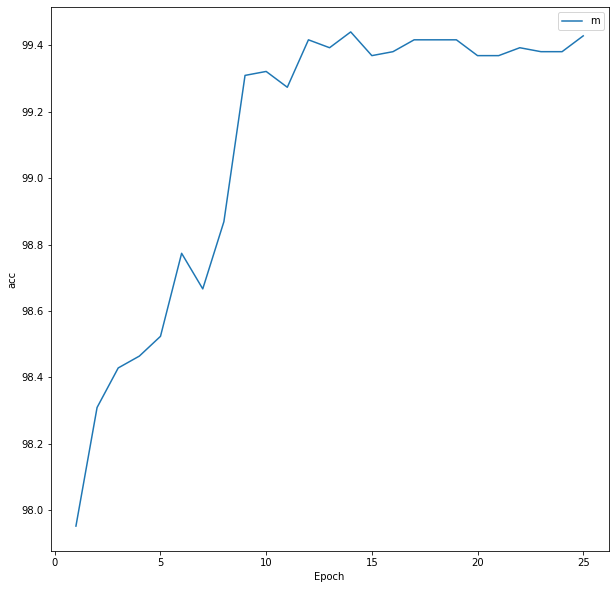

In [ ]:
epoch_count = range(1, 26)

# plot accuracy or loss graph
def plot_graphs(name, type_='acc'):
    "
    fig = plt.figure(figsize=(10,10))
    plt.plot(epoch_count, validation_stat(name, type_))
    
    plt.legend(name)
    plt.xlabel('Epoch')
    plt.ylabel(type_)
    plt.show();
# plot misclassified images

def plot_misclassified_images(name, n=25):
    
    figure = plt.figure(figsize=(10,10))
    
    images = get_misclassified_images(name)[:n]
    
    for i in range(1, n+1):
        plt.subplot(5,5,i)
        plt.axis('off')
        plt.imshow(images[i-1]["img"].cpu().numpy()[0], cmap='gray_r')
        plt.title("Predicted : {} \nActual : {}".format(images[i-1]["pred"][0].cpu().numpy(), images[i-1]["target"].cpu().numpy()))

    plt.tight_layout()
# model name
name = "mnist_model_03"
# stats file path where we have stores accuracy and loss scores
stats_file_path = "./stats/acc_losses_{}.json".format(name)
# plot accuracy graph
plot_graphs(name, 'acc')

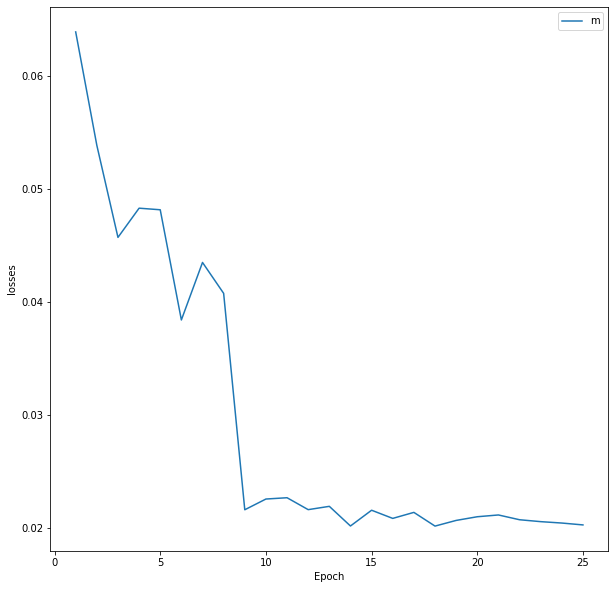

In [ ]:
# plot loss graph
plot_graphs(name, 'losses')

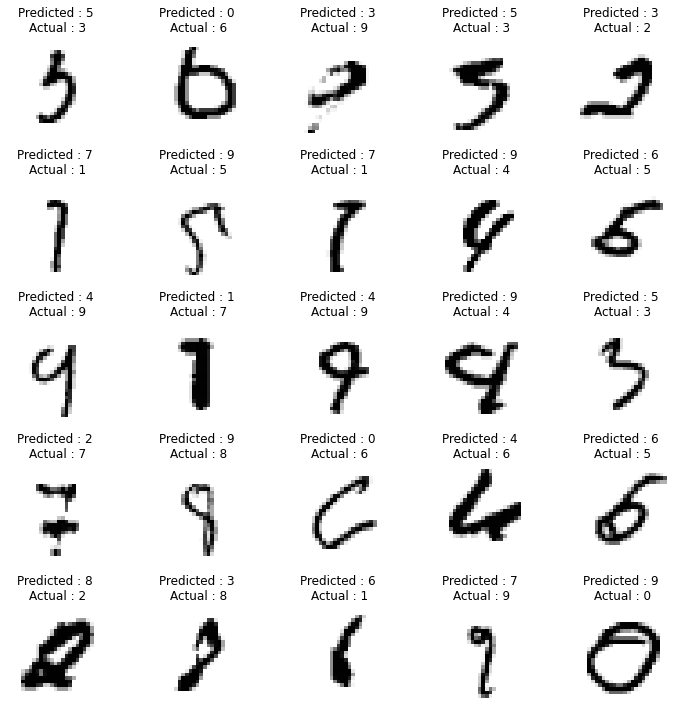

In [ ]:
# plot misclassified images for our best model
plot_misclassified_images(name)